# Problem 3 Naive Bayes

## 3.1 implement a Naive Bayes classifier

In [3]:
import sys
import itertools
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import time
from copy import deepcopy

In [27]:
class Model:
    def __init__(self, wordlist):
        self.wordlist = wordlist

    def count_labels(self, data):
        """
        Count the number of positive labels and negative labels.
        Returns (a tuple or a numpy array of two elements):
            * negative_count: a non-negative integer, which represents the number of negative labels;
            * positive_count: a non-negative integer, which represents the number of positive labels.
        """

        positive_count = sum([y for y, x in data])
        negative_count = len(data) - positive_count
        return np.array([negative_count, positive_count])

    def count_words(self, wordlist, data):
        """
        Count the number of times that each word appears in emails under a given label.
        Returns (a numpy array):
            * word_counts: a numpy array with shape (2, L), where L is the length of $wordlist,
                - word_counts[0, i] represents the number of times that word $wordlist[i] appears in non-spam (negative) emails, and
                - word_counts[1, i] represents the number of times that word $wordlist[i] appears in spam (positive) emails.
        """

        word_counts = np.zeros((2, len(wordlist)), dtype=np.float32)
        for y, x in data:
            # we consider binary (0/1) occurrence of word for Naive Bayes, so a word set is taken here
            for w in set(x):
                if w in wordlist:
                    word_counts[int(y), wordlist[w]] += 1
        return word_counts

    def calculate_probability(self, label_counts, word_counts):
        """
        Calculate the probabilities, both the prior and likelihood.
        Returns (a pair of numpy array):
            * prior_probs: a numpy array with shape (2, ), only two elements, where
                - prior_probs[0] is the prior probability of negative labels, and
                - prior_probs[1] is the prior probability of positive labels.
            * likelihood_probs: a numpy array with shape (2, L), where L is the length of the word list,
                - likelihood_probs[0, i] represents the likelihood probability of the $i-th word in the word list, given that the email is non-spam (negative), and
                - likelihood_probs[1, i] represents the likelihood probability of the $i-th word in the word list, given that the email is spam (positive).
        """
        prior_probs = label_counts / label_counts.sum()        
        likelihood_probs = (word_counts + 1) / (label_counts + 2).reshape(-1, 1)
        return prior_probs, likelihood_probs

    def fit(self, data):
        label_counts = self.count_labels(data)
        word_counts = self.count_words(self.wordlist, data)

        self.prior_probs, self.likelihood_probs = self.calculate_probability(label_counts, word_counts)

        # TO AVOID NUMBER OVERFLOW here we use log probability instead.
        self.log_prior_probs = np.log(self.prior_probs)
        self.log_likelihood_probs = np.dstack([np.log(1 - self.likelihood_probs), np.log(self.likelihood_probs)])

    def predict(self, x):
        """
        Predict whether email $x is a spam or not.
        Returns:
            * y: a boolean value indicating whether $x is a spam or not.
        """        
        x_set = set(x)
        word_idx = list(range(len(self.wordlist)))
        is_occur = [int(word in x_set) for word in self.wordlist]
        
        # select all classes, followed by selecting from array word_idx, is_occur
        # after selection, shape is [2, len(wordlist)]
        preds = self.log_prior_probs + self.log_likelihood_probs[:, word_idx, is_occur].sum(axis=1)
        
        # print ('shape of preds',preds.shape)
        return preds[1] >= preds[0]

In [28]:
a = np.array([0.01,0.3,0.333,0.44,0.9,0.5]).reshape(2,3)

In [29]:
a

array([[0.01 , 0.3  , 0.333],
       [0.44 , 0.9  , 0.5  ]])

In [30]:
np.log(a)

array([[-4.60517019, -1.2039728 , -1.09961279],
       [-0.82098055, -0.10536052, -0.69314718]])

In [31]:
np.log(1-a)

array([[-0.01005034, -0.35667494, -0.40496523],
       [-0.5798185 , -2.30258509, -0.69314718]])

In [32]:
b = np.dstack([np.log(1 - a), np.log(a)])
b

array([[[-0.01005034, -4.60517019],
        [-0.35667494, -1.2039728 ],
        [-0.40496523, -1.09961279]],

       [[-0.5798185 , -0.82098055],
        [-2.30258509, -0.10536052],
        [-0.69314718, -0.69314718]]])

In [33]:
word_idx = [0,1,2]
is_occur = [1,0,0]
b[:, word_idx, is_occur]

array([[-4.60517019, -0.35667494, -0.40496523],
       [-0.82098055, -2.30258509, -0.69314718]])

In [34]:
c = np.array([1,2,3,4]).reshape(2,2)
print (c)
d = np.array([10,20]).reshape(-1,1)
print (d)
print (c/d)

[[1 2]
 [3 4]]
[[10]
 [20]]
[[0.1  0.2 ]
 [0.15 0.2 ]]


In [35]:
# threshold to determine whether to include a word in the dictionary/wordlist.
# ie. only words with frequency higher than threshold are included
THRESHOLD = 26

def read_data(filename):
    """
    Read the dataset from the file given by name $filename.
    The returned object should be a list of pairs of data, such as
        [
            (True , ['a', 'b', 'c']),
            (False, ['d', 'e', 'f']),
            ...
        ]
    """
    with open(filename, 'r') as f:
        return [(int(y), x) for y, *x in [line.strip().split() for line in f]]


def split_train(original_train_data, size=4000):
    return original_train_data[:size], original_train_data[size:]


def create_wordlist(original_train_data, threshold=26):
    """
    Create a word list from the original training set.
    Only get a word if it appears in at least $threshold emails.
    """
    # tokens: a word list containing all the words in training data
    # wordlist: contains all words that appear at or above the threshold
    tokens = itertools.chain(*[set(x) for y, x in original_train_data])
    wordlist = [w for w, c in Counter(tokens).items() if c >= threshold]
    
    # Use a hash table for fast lookup of word index from word string
    wordlist_dict = {w:i for i, w in enumerate(wordlist)}
    return wordlist_dict

In [36]:
## read file
with open('spam_train.txt', 'r') as f:
    first_line = f.readline()
    f_list = first_line.strip().split()
    for x, *y in [f_list]:
        print (x)
        print (y)        
Counter(y)

1
['public', 'announc', 'the', 'new', 'domain', 'name', 'ar', 'final', 'avail', 'to', 'the', 'gener', 'public', 'at', 'discount', 'price', 'now', 'you', 'can', 'regist', 'on', 'of', 'the', 'excit', 'new', 'biz', 'or', 'info', 'domain', 'name', 'as', 'well', 'as', 'the', 'origin', 'com', 'and', 'net', 'name', 'for', 'just', 'dollarnumb', 'number', 'these', 'brand', 'new', 'domain', 'extens', 'were', 'recent', 'approv', 'by', 'icann', 'and', 'have', 'the', 'same', 'right', 'as', 'the', 'origin', 'com', 'and', 'net', 'domain', 'name', 'the', 'biggest', 'benefit', 'is', 'of', 'cours', 'that', 'the', 'biz', 'and', 'info', 'domain', 'name', 'ar', 'current', 'more', 'avail', 'i', 'e', 'it', 'will', 'be', 'much', 'easier', 'to', 'regist', 'an', 'attract', 'and', 'easi', 'to', 'rememb', 'domain', 'name', 'for', 'the', 'same', 'price', 'visit', 'httpaddr', 'todai', 'for', 'more', 'info', 'regist', 'your', 'domain', 'name', 'todai', 'for', 'just', 'dollarnumb', 'number', 'at', 'httpaddr', 'regist

Counter({'public': 2,
         'announc': 1,
         'the': 10,
         'new': 3,
         'domain': 10,
         'name': 8,
         'ar': 2,
         'final': 1,
         'avail': 2,
         'to': 7,
         'gener': 1,
         'at': 2,
         'discount': 1,
         'price': 2,
         'now': 1,
         'you': 1,
         'can': 1,
         'regist': 3,
         'on': 1,
         'of': 2,
         'excit': 1,
         'biz': 2,
         'or': 1,
         'info': 3,
         'as': 3,
         'well': 1,
         'origin': 2,
         'com': 2,
         'and': 5,
         'net': 2,
         'for': 4,
         'just': 2,
         'dollarnumb': 2,
         'number': 3,
         'these': 1,
         'brand': 1,
         'extens': 1,
         'were': 1,
         'recent': 1,
         'approv': 1,
         'by': 1,
         'icann': 1,
         'have': 1,
         'same': 2,
         'right': 1,
         'biggest': 1,
         'benefit': 1,
         'is': 1,
         'cours': 1,
 

In [37]:
original_train_data = read_data('spam_train.txt')

train_data, val_data = split_train(original_train_data)

# Create the word list.

time1 = time.time()
wordlist = create_wordlist(original_train_data, 26)
print("Total # of words:", len(wordlist))

model = Model(wordlist)
model.fit(train_data)

error_count = sum([y != model.predict(x) for y, x in val_data])
time2 = time.time()
error_percentage = error_count / len(val_data) * 100
print('Time: {}'.format(time2 - time1))
print("Validation error, # = {:>4d}, % = {:>8.4f}%.".format(error_count, error_percentage))

Total # of words: 3048
Time: 2.0342869758605957
Validation error, # =   61, % =   6.1000%.


## 3.2 try different thresholds, find the optimal threshold (which gives minimum validation error), print out the test error at the optimal threshold

In [38]:
def compute_error_rate(model, data):
    error_count = sum([y != model.predict(x) for y, x in data])
    return 100.0 * error_count / len(data)

In [39]:
thresholds = list(range(1, 35))
train_error = []
val_error = []
test_error = []
original_train_data = read_data('spam_train.txt')
train_data, val_data = split_train(original_train_data)
test_data = read_data('spam_test.txt')

In [40]:
for th in thresholds:
    print('With threshold {}....'.format(th))
    time1 = time.time()

    # vocabulary selection
    wordlist = create_wordlist(original_train_data, th)

    # fit model using the wordlist
    model = Model(wordlist)
    model.fit(train_data)

    # compute classification error rates
    err_train = compute_error_rate(model, train_data)
    err_val = compute_error_rate(model, val_data)
    err_test = compute_error_rate(model, test_data)

    # store results for plotting
    train_error.append(err_train)
    val_error.append(err_val)
    test_error.append(err_test)

    time2 = time.time()
    print("train:{} val:{} test:{} len(V)={}".format(err_train, err_val, err_test, len(wordlist)))
    print('time: {}'.format(time2 - time1))

With threshold 1....
train:12.275 val:14.7 test:16.5 len(V)=65812
time: 94.56785202026367
With threshold 2....
train:4.45 val:6.1 test:7.3 len(V)=19298
time: 29.24763011932373
With threshold 3....
train:4.0 val:5.4 test:5.9 len(V)=12882
time: 19.700134992599487
With threshold 4....
train:3.975 val:5.5 test:5.3 len(V)=10362
time: 16.038599014282227
With threshold 5....
train:3.95 val:5.5 test:5.2 len(V)=8773
time: 13.829952001571655
With threshold 6....
train:4.1 val:5.6 test:5.4 len(V)=7803
time: 12.48328185081482
With threshold 7....
train:4.225 val:5.5 test:5.4 len(V)=7085
time: 11.41461992263794
With threshold 8....
train:4.2 val:5.1 test:5.5 len(V)=6493
time: 10.55123496055603
With threshold 9....
train:4.4 val:5.1 test:6.0 len(V)=5982
time: 9.815671920776367
With threshold 10....
train:4.55 val:5.0 test:6.1 len(V)=5603
time: 9.303005933761597
With threshold 11....
train:4.55 val:5.1 test:6.2 len(V)=5303
time: 8.961062908172607
With threshold 12....
train:4.625 val:5.0 test:6.2 len

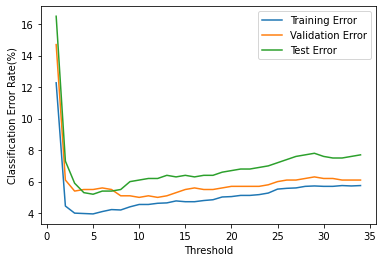

Best performance at validated threshold 9 with test error rate 6.0.


In [42]:
plt.plot(thresholds, train_error, label='Training Error')
plt.plot(thresholds, val_error, label='Validation Error')
plt.plot(thresholds, test_error, label='Test Error')
plt.xlabel('Threshold')
plt.ylabel('Classification Error Rate(%)')
plt.legend()
plt.show()
opt = np.argmin(val_error)
print('Best performance at validated threshold {} with test error rate {}.'.format(opt, test_error[opt-1]))

In [1]:
True == 1

True